In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


clients = pd.read_csv('../data/Clients.csv', delimiter=';', encoding='latin1')
commandes = pd.read_csv('../data/Commandes.csv', delimiter=';', encoding='latin1')
envois_chunks = pd.read_csv('../data/Envois.csv', delimiter=';', encoding='latin1', chunksize=500000)
envois = envois_chunks.get_chunk()
produits = pd.read_csv('../data/Produits.csv', delimiter=';', encoding='latin1')

In [3]:
# Create age groups
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
clients['Age Group'] = pd.cut(clients['Age'], bins=bins, labels=labels, include_lowest=True)

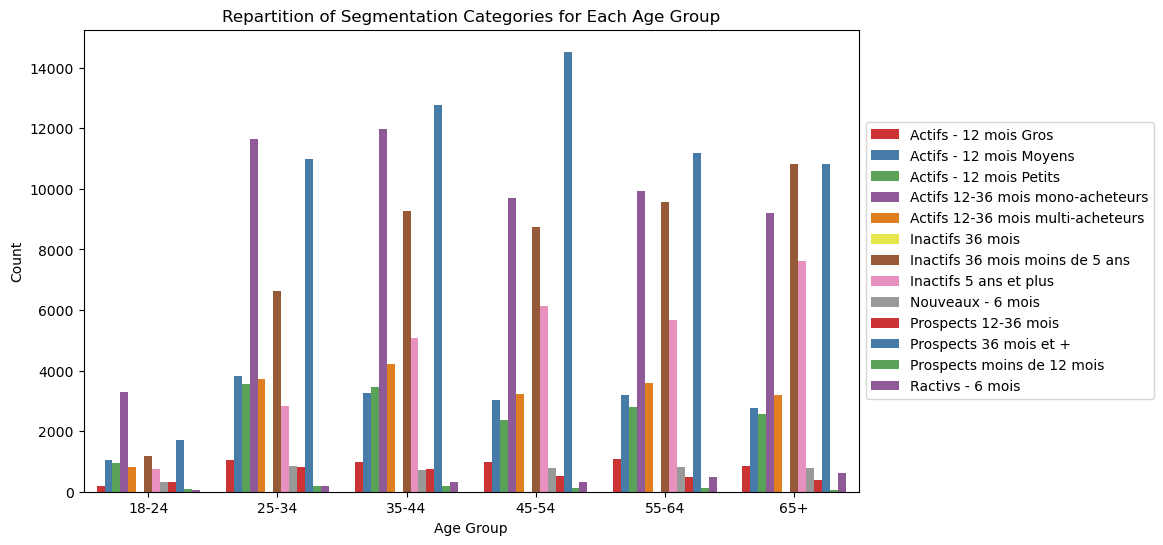

In [4]:
# Count the number of clients in each age group and segmentation category
age_segment_counts = clients.groupby(['Age Group', 'Segmentation']).size().reset_index(name='Count')

# Create a unique plot for the distribution of segmentation categories for each age group
plt.figure(figsize=(10, 6))
sns.barplot(data=age_segment_counts, x='Age Group', y='Count', hue='Segmentation', palette='Set1')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Repartition of Segmentation Categories for Each Age Group')
plt.show()

In [5]:
# merge clients & commandes
merged_clients_comm = pd.merge(clients, commandes, on='id_client', how='inner')

# merge commandes & produits
merged_comm_prod = pd.merge(commandes, produits, on='id_produit', how='inner')

# merge all three tables
merged_clients_comm_prod = pd.merge(merged_clients_comm, produits, on='id_produit', how='inner')
merged_clients_comm_prod['Montant_Produit'] = merged_clients_comm_prod['Montant_Produit'].str.replace(',', '.').astype(float)
merged_clients_comm_prod['Montant_Remise'] = merged_clients_comm_prod['Montant_Remise'].str.replace(',', '.').astype(float)

Produit A    198262
Produit B    133663
Produit C     48217
Produit D     44720
Name: Categorie_Produit, dtype: int64


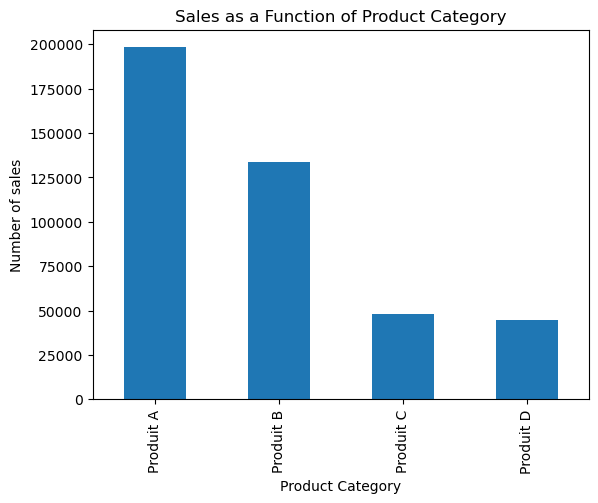

In [6]:
# Get the number of occurrences of each product type
product_counts = merged_clients_comm_prod['Categorie_Produit'].value_counts()

print(product_counts)
product_counts.plot(kind='bar')
plt.xlabel('Product Category')
plt.ylabel('Number of sales')
plt.title('Sales as a Function of Product Category')
plt.show()


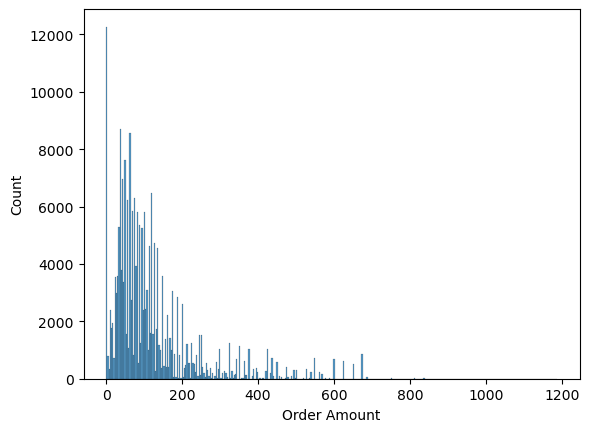

118.03170283986009


In [7]:
# Filter the data to only include punctual buyers who have made 3 or less commands
punctual_buyers = merged_clients_comm_prod.groupby('id_client').filter(lambda x: len(x) <= 3)

# Plot the distribution of order amounts for punctual buyers
sns.histplot(data=punctual_buyers, x='Montant_Produit', kde=False)
plt.xlabel('Order Amount')
plt.ylabel('Count')
plt.show()

mean_punctual = punctual_buyers['Montant_Produit'].mean()
print(mean_punctual)

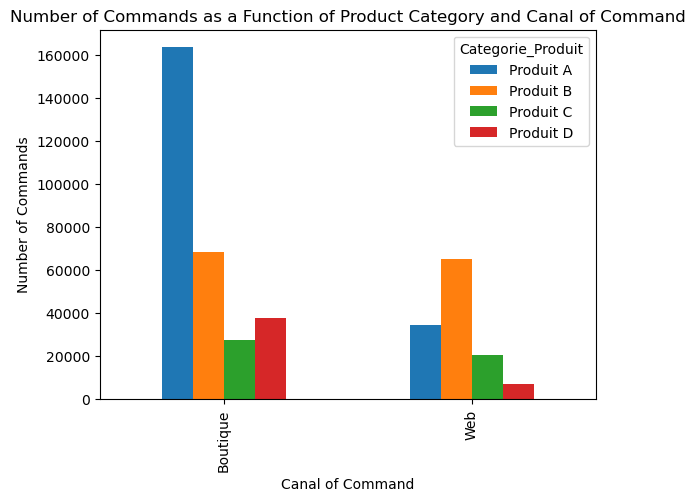

In [8]:
# Create a pivot table with the number of commands for each product category and canal of command
command_counts = merged_comm_prod.pivot_table(index='Canal_Commande', columns='Categorie_Produit', values='id_commande', aggfunc='count')

# Create a bar plot of the pivot table
command_counts.plot(kind='bar')
plt.xlabel('Canal of Command')
plt.ylabel('Number of Commands')
plt.title('Number of Commands as a Function of Product Category and Canal of Command')
plt.show()


In [9]:
# Calculate mean amount spent per client as a function of age group
mean_amounts = merged_clients_comm_prod.groupby('Age Group')['Montant_Produit'].mean()

# Plot the mean amount spent per client as a function of age group
"""plt.plot(mean_amounts.index, mean_amounts.values)
plt.xlabel('Age Group')
plt.ylabel('Mean Amount Spent per Client')
plt.title('Mean Amount Spent per Client as a Function of Age Group')
plt.show()"""
print(mean_amounts)

Age Group
18-24    115.171442
25-34    107.545066
35-44     99.841876
45-54    113.358810
55-64    110.211297
65+      110.122101
Name: Montant_Produit, dtype: float64


# Create validation set

In [37]:
data_df = merged_clients_comm_prod.copy()

# Count of orders by Boutique and Web per client
web_counts = data_df[data_df['Canal_Commande'] == 'Web'].groupby('id_client').size().reset_index(name='Web_Count')
boutique_counts = data_df[data_df['Canal_Commande'] == 'Boutique'].groupby('id_client').size().reset_index(name='Boutique_Count')

result = pd.merge(web_counts, boutique_counts, on='id_client', how='outer').fillna(0).astype(int)

# nombre total de commandes dans les 12, 6 et 3 derniers mois
count_orders_year = data_df[data_df['dCommande'] > '2022-07-01'].groupby('id_client').size().reset_index(name='Count_Orders_year')
count_orders_6 = data_df[data_df['dCommande'] > '2023-01-01'].groupby('id_client').size().reset_index(name='Count_Orders_6months')
count_orders_3 = data_df[data_df['dCommande'] > '2023-04-01'].groupby('id_client').size().reset_index(name='Count_Orders_3months')

# Total amount spent per id_client
amount_spent = data_df.groupby('id_client')['Montant_Produit'].sum().reset_index(name='Total_Amount_Spent')

# Count of products bought in their launch year
data_df['Year'] = pd.to_datetime(data_df['dCommande']).dt.year
count_orders_launch_year = data_df[data_df['Year'] == data_df['Annee_lancement_produit']].groupby('id_client').size().reset_index(name='Count_Orders_Launch_Year')

result = pd.merge(result, count_orders_year, on='id_client', how='inner').astype(int)
result = pd.merge(result, count_orders_3, on='id_client', how='inner').astype(int)
result = pd.merge(result, count_orders_6, on='id_client', how='inner').astype(int)
result = pd.merge(result, amount_spent, on='id_client', how='inner').astype(float)
result = pd.merge(result, count_orders_launch_year, on='id_client', how='inner').astype(int)

# Count of orders placed after a limit date
limit_date = '2023-01-01'

orders_after = data_df[data_df['dCommande'] >= limit_date]
order_counts = orders_after.groupby('id_client').size().reset_index(name='Orders_After')

result = pd.merge(result, order_counts, on='id_client', how='inner')


# Final merge 
dataset_af = pd.merge(clients, result, on='id_client', how='inner')

dataset_af['dPremierEnvoi'] = pd.to_datetime(dataset_af['dPremierEnvoi'])
dataset_af['dPremiereCommande'] = pd.to_datetime(dataset_af['dPremiereCommande'])

dataset_af = dataset_af.dropna(subset=['dPremierEnvoi', 'dPremiereCommande'])
dataset_af = dataset_af.dropna()
dataset_af = pd.get_dummies(dataset_af, columns=['Segmentation'])

print(dataset_af.columns)

Index(['id_client', 'Host', 'Civilite', 'Pays', 'Age', 'Anciennete_Compte',
       'ZoneGeographique', 'dPremierEnvoi', 'dPremiereCommande',
       'Member_Programme_de_fid', 'A_ete_Membre_Programme_de_fid', 'Age Group',
       'Web_Count', 'Boutique_Count', 'Count_Orders_year',
       'Count_Orders_3months', 'Count_Orders_6months', 'Total_Amount_Spent',
       'Count_Orders_Launch_Year', 'Orders_After',
       'Segmentation_Actifs - 12 mois Gros',
       'Segmentation_Actifs - 12 mois Moyens',
       'Segmentation_Actifs - 12 mois Petits',
       'Segmentation_Actifs 12-36 mois mono-acheteurs',
       'Segmentation_Actifs 12-36 mois multi-acheteurs',
       'Segmentation_Nouveaux - 6 mois', 'Segmentation_Ractivs - 6 mois'],
      dtype='object')


# Create training set

In [38]:
# Filter the data based on the date of the commandes
train_date = '2023-04-01'
data_bf = merged_clients_comm_prod.copy()[merged_clients_comm_prod['dCommande'] <= train_date]

# Count of orders by Boutique and Web per client
web_counts = data_bf[data_bf['Canal_Commande'] == 'Web'].groupby('id_client').size().reset_index(name='Web_Count')
boutique_counts = data_bf[data_bf['Canal_Commande'] == 'Boutique'].groupby('id_client').size().reset_index(name='Boutique_Count')

result = pd.merge(web_counts, boutique_counts, on='id_client', how='outer').fillna(0).astype(int)

# nombre total de commandes dans les 12, 6 et 3 derniers mois
count_orders_year = data_bf[data_bf['dCommande'] > '2022-04-01'].groupby('id_client').size().reset_index(name='Count_Orders_year')
count_orders_6 = data_bf[data_bf['dCommande'] > '2022-10-01'].groupby('id_client').size().reset_index(name='Count_Orders_6months')
count_orders_3 = data_bf[data_bf['dCommande'] > '2023-01-01'].groupby('id_client').size().reset_index(name='Count_Orders_3months')

# Total amount spent per id_client
amount_spent = data_bf.groupby('id_client')['Montant_Produit'].sum().reset_index(name='Total_Amount_Spent')

# Count of products bought in their launch year
data_bf['Year'] = pd.to_datetime(data_bf['dCommande']).dt.year
count_orders_launch_year = data_bf[data_bf['Year'] == data_bf['Annee_lancement_produit']].groupby('id_client').size().reset_index(name='Count_Orders_Launch_Year')

result = pd.merge(result, count_orders_year, on='id_client', how='inner').astype(int)
result = pd.merge(result, count_orders_3, on='id_client', how='inner').astype(int)
result = pd.merge(result, count_orders_6, on='id_client', how='inner').astype(int)
result = pd.merge(result, amount_spent, on='id_client', how='inner').astype(float)
result = pd.merge(result, count_orders_launch_year, on='id_client', how='inner').astype(int)

# Count of orders placed after a limit date
limit_date = '2023-01-01'

orders_after = data_bf[data_bf['dCommande'] >= limit_date]
order_counts = orders_after.groupby('id_client').size().reset_index(name='Orders_After')

result = pd.merge(result, order_counts, on='id_client', how='inner')

# Final merge 
dataset_bf = pd.merge(clients, result, on='id_client', how='inner')

dataset_bf['dPremierEnvoi'] = pd.to_datetime(dataset_bf['dPremierEnvoi'])
dataset_bf['dPremiereCommande'] = pd.to_datetime(dataset_bf['dPremiereCommande'])

dataset_bf = dataset_bf.dropna()

dataset_bf = pd.get_dummies(dataset_bf, columns=['Segmentation'])

dataset_bf['Segmentation_Actifs 12-36 mois multi-acheteurs'] = 0
dataset_bf['Segmentation_Nouveaux - 6 mois'] = 0
dataset_bf['Segmentation_Ractivs - 6 mois'] = 0

print(dataset_bf.columns)

Index(['id_client', 'Host', 'Civilite', 'Pays', 'Age', 'Anciennete_Compte',
       'ZoneGeographique', 'dPremierEnvoi', 'dPremiereCommande',
       'Member_Programme_de_fid', 'A_ete_Membre_Programme_de_fid', 'Age Group',
       'Web_Count', 'Boutique_Count', 'Count_Orders_year',
       'Count_Orders_3months', 'Count_Orders_6months', 'Total_Amount_Spent',
       'Count_Orders_Launch_Year', 'Orders_After',
       'Segmentation_Actifs - 12 mois Gros',
       'Segmentation_Actifs - 12 mois Moyens',
       'Segmentation_Actifs - 12 mois Petits',
       'Segmentation_Actifs 12-36 mois mono-acheteurs',
       'Segmentation_Actifs 12-36 mois multi-acheteurs',
       'Segmentation_Nouveaux - 6 mois', 'Segmentation_Ractivs - 6 mois'],
      dtype='object')


In [39]:
# Step 1: Preprocess the data

# Drop unnecessary columns
cols_to_drop = ['id_client', 'Host', 'Civilite', 'Age Group', 'ZoneGeographique', 'Pays', 'dPremierEnvoi', 'dPremiereCommande']
dataset_bf = dataset_bf.drop(cols_to_drop, axis=1, errors='ignore')

# Normalize numerical variables
scaler = StandardScaler()
numerical_cols = ['Web_Count', 'Boutique_Count', 'Count_Orders_year', 'Count_Orders_3months', 'Count_Orders_6months', 'Total_Amount_Spent', 
                  'Count_Orders_Launch_Year']
dataset_bf[numerical_cols] = scaler.fit_transform(dataset_bf[numerical_cols])

# Split the data into training and validation sets
train_data, test_data = train_test_split(dataset_bf, test_size=0.2, random_state=42)

# Step 2: Build the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 3: Train the model
train_inputs = train_data.drop('Orders_After', axis=1)
train_labels = train_data['Orders_After']
test_inputs = test_data.drop('Orders_After', axis=1)
test_labels = test_data['Orders_After']

model.fit(train_inputs, train_labels)

# Step 4: Test the model

# Preprocess the validation data 
test_data = test_data.drop(cols_to_drop, axis=1, errors='ignore')
test_data[numerical_cols] = scaler.fit_transform(test_data[numerical_cols])

# Use the trained model to make predictions on the validation data
predictions = model.predict(test_inputs)

# Get the actual labels from the validation dataset
accuracy = accuracy_score(test_labels, predictions)
accuracy

0.9740791268758526

In [40]:
from sklearn.svm import SVC

# Step 1: Preprocess the data (same as before)

# Step 2: Build the model
model = SVC(kernel='linear', random_state=42)

# Step 3: Train the model (same as before)
model.fit(train_inputs, train_labels)

# Step 4: Test the model on 'dataset' (same as before)
predictions = model.predict(test_inputs)

# Calculate the accuracy of the model (same as before)
accuracy = accuracy_score(test_labels, predictions)
accuracy


0.9836289222373806

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

# Step 1: Preprocess the data (same as before)

# Step 2: Build the model
model = GradientBoostingClassifier(random_state=42)

# Step 3: Train the model (same as before)
model.fit(train_inputs, train_labels)

# Step 4: Test the model on 'dataset' (same as before)
predictions = model.predict(test_inputs)

# Calculate the accuracy of the model (same as before)
accuracy = accuracy_score(test_labels, predictions)
accuracy


0.990450204638472

In [44]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Preprocess the data (same as before)
input_size = train_inputs.shape[1]  # Using shape[1] to get the number of columns

# Convert the input data to tensors
train_inputs_tensor = torch.tensor(train_inputs.values, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.float32).view(-1, 1)  # Reshape the labels
test_inputs_tensor = torch.tensor(test_inputs.values, dtype=torch.float32)

# Step 2: Build the model
model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)  # Removed Sigmoid for regression
)

# Step 3: Train the model (same as before)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for inputs, labels in zip(train_inputs_tensor, train_labels_tensor):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_inputs_tensor)}")

# Step 4: Test the model on 'val_inputs_tensor'
with torch.no_grad():
    predictions = model(test_inputs_tensor)

# Convert predictions and labels to numpy arrays for easier evaluation
predictions_np = predictions.numpy()

# Evaluate your regression model using appropriate metrics (e.g., Mean Absolute Error, Mean Squared Error)
mae = mean_absolute_error(test_labels, predictions_np)
mse = mean_squared_error(test_labels, predictions_np)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Epoch 1 loss: 1.0669431011609152
Epoch 2 loss: 1.0379187941342782
Epoch 3 loss: 0.08480498270172407
Epoch 4 loss: 0.10246621293422223
Epoch 5 loss: 0.1655455115818092
Epoch 6 loss: 0.18633875474272876
Epoch 7 loss: 0.5765639160524948
Epoch 8 loss: 0.21206501009825585
Epoch 9 loss: 0.1763837208196432
Epoch 10 loss: 0.22393123591108524
Mean Absolute Error: 0.05573226013417784
Mean Squared Error: 0.022534381591808098


In [45]:
# Step 1: Preprocess the data

# Drop unnecessary columns
cols_to_drop = ['id_client', 'Host', 'Civilite', 'Age Group', 'ZoneGeographique', 'Pays', 'dPremierEnvoi', 'dPremiereCommande']
dataset_af = dataset_af.drop(cols_to_drop, axis=1, errors='ignore')

# Normalize numerical variables
scaler = StandardScaler()
numerical_cols = ['Web_Count', 'Boutique_Count', 'Count_Orders_year', 'Count_Orders_3months', 'Count_Orders_6months', 'Total_Amount_Spent', 
                  'Count_Orders_Launch_Year']
dataset_af[numerical_cols] = scaler.fit_transform(dataset_af[numerical_cols])

# Split in inputs and labels sets
val_inputs = dataset_af.drop('Orders_After', axis=1)
val_labels = dataset_af['Orders_After']

input_size = val_inputs.shape[1]  # Using shape[1] to get the number of columns

# Convert the input data to a tensor
val_inputs_tensor = torch.tensor(val_inputs.values, dtype=torch.float32)

# Step 2: Use the trained DL model to make predictions
with torch.no_grad():
    predictions = model(val_inputs_tensor)

# Step 3: Convert the predictions to the desired format
predictions_np = predictions.numpy()

mae = mean_absolute_error(val_labels, predictions_np)
mse = mean_squared_error(val_labels, predictions_np)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')


Mean Absolute Error: 0.9077636606854164
Mean Squared Error: 7.029319574786921
